# Data Analysis - Netflix prize data

## Parent problem

Dataset from Netflix Prize Data competition to improve their recommendation system.

Original blog: [http://netflixprize.com/index.html] <br>
Kaggle blog: [https://www.kaggle.com/netflix-inc/netflix-prize-data]

### Some key pointers:
* It was a competition for the best collaborative filtering algorithm to predict user rating of films.
* Training dataset of 100,480,507 ratings that 480,189 users gave to 17,770 movies.
* Quadruplet (user, movie, date of grading, grade)
* Size of matrix is ~8.5 Billion, ~100 Million points present, ~8.4 Billion points missing.
* Highly sparse
* Qualifying dataset, 2,817,131 points. 
* Triplet format (user, movie, date of grade)
* The ratings have been withheld.


### Deeper into Qualifying dataset:
* Divided into two parts 'Quiz' and 'Test'.
* Score for Quiz dataset was mentioned.
* The contents of the ‘Quiz’ and ‘Test’ dataset has been kept confidential to prevent hill climb(local optimization).
* Performance on the test dataset will determine the winner.
* Predictions can be real values

### Task during the competition: 
1. The final algorithm must predict all the ratings the customer gave, from the Qualifying dataset.
2. Reduce the RMSE on the Qualifying dataset.
3. Try to beat Cinematch by 10%.

### Papers by three contributors of winning solution:
* BellKor Solution [http://netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf]
* Big Chaos solution [http://netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf]
* Pragmatic Solution [http://netflixprize.com/assets/GrandPrize2009_BPC_PragmaticTheory.pdf]

***

## Our take on the problem:
* The original data from the netflix blog came in more than 17000 files.
* Kaggle combines the training data and provides us in 4 different files.
* The qualifying dataset doesn’t have the ‘ground truth’ and hence we can’t test our model on it.
    * Way around it is, to use the probe set that netflix has provided.[Note: Separate it from the training dataset first]
    * Or, sample and separate from the training set.


### Understanding of the data:
There are primarily 8 files when downloaded from kaggle<br>
1. Movie_titles.csv
2. Combined_data_1.txt
3. Combined_data_2.txt
4. Combined_data_3.txt
5. Combined_data_4.txt
6. Probe.txt
7. Qualifying.txt
8. README


**Filename:**  Movie_titles.csv<br>
**Format :**   (MovieID, Year, Title)<br>
**Description of features:<br>**
MovieID is an integer ranging from 1 to 17,770 and present in a sequential fashion. This does neither correspond with Imdb movie ID or Netflix movie ID.
Year is the Year of release of the corresponding DVD and may not be the theatrical release. It is an integer and ranges from 1890 to 2005.
Title is a the Netflix movie title in english. It’s in string format.

**Filename:** Combined_data_1.txt<br>
**Format:**   MovieID:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;
CustomerID,Score,Date
<br>**Description of features:**<br>
MovieID is same a in Movie_titles.csv
CustomerID is an integer ranging from 1 to 2649429. These are not the actual Netflix CustomerID. They have been changed due to privacy issues.
Score is the integral number of stars the user rated to that particular movie.
Date is the date of grading. It is in the format YYYY-MM-DD.

**Filename:** Qualifying.txt<br>
**Format:**   MovieID:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;
	    CustomerID,Date
<br>**Description of features:**<br>
MovieID is same a in Movie_titles.csv
CustomerID is an integer ranging from 1 to 2649429. These are not the actual Netflix CustomerID. They have been changed due to privacy issues.
Date is the date of grading. It is in the format YYYY-MM-DD.

Probe data is basically a subset of the training dataset.
Format: MovieID:
	  CustomerID

### What we hope to do with the ‘Netflix prize data’ [PROBLEM STATEMENT]:
1. Predict ratings that a particular user might give to an unrated movie.
2. Recommend him top 5 movies that he might rate highly.

## Challenges:
The data was present in a compressed fashion. From there it had to be converted to a tabular format. Upon doing so, the size became more than 3.5gb. Due to limited hardware it was impossible to work on the complete dataset. Therefore only the first file (combine_data_1.txt) was chosen

Note: Over the whole notebook, you'll find me deleting variables. This was done due to the limitations of hardware

I wrote a small script to change the file format so that it's easier to work with

In [ ]:
'''
fopen = open("combined_data_1.txt",'r')
fwrite = open("Whole_dataset1.txt",'a+')

fopen.seek(0); fwrite.seek(0)

fwrite.writelines('CustomerID,Score,Date,MovieID\n')

for line in fopen.readlines():
    line = line.strip()
    if(line[-1] == ':'):
        movie_id = line[:-1]
    else:
        fwrite.writelines(line+','+movie_id+'\n')

fopen.close(); fwrite.close()\
'''

In [27]:
from sys import getsizeof

In [1]:
import pandas as pd

In [29]:
'''This Data analysis is done on a part of the data and not the whol
due to the limitations in the hardware'''
df = pd.read_csv('Whole_dataset1.txt')

## About  the dataset:

In [30]:
df.columns

Index(['CustomerID', 'Score', 'Date', 'MovieID'], dtype='object')

In [31]:
print ('Number of ratings: {}\nUnique Customers: {}\nNumber of movies: {}'\
       .format(df.shape[0],len(set(df.CustomerID)),len(set(df.MovieID))))

Number of ratings: 24053764
Unique Customers: 470758
Number of movies: 4499


So we can see there are 24,053,764 elements in the sparse matrix of size 470758x4499.<br>
Therefore only 1.13% of the matrix is filled.

## Plots:

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

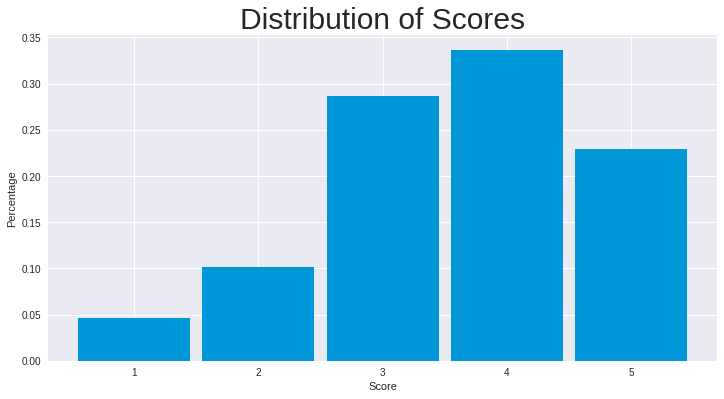

In [33]:
'''Plotting the histogram of scores'''
plt.figure(figsize=(12,6))
plt.hist(x=list(df.Score),bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color='#0097D9');
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_scores.png')
plt.show()

So we can see 4(~33%) stars is given the most, then 3(~28%) stars, then 5(~22.5%), then 2(~10%) and at last 1(~5%)

In [34]:
'''Loading the year of movies'''
year_of_movies = pd.read_csv('movie_info_formatted.txt').Year.tolist()
year_of_movies = year_of_movies[:4499]

While trying to plot the distribution of the year of movie releases, we found out that there were some missing data in year column in the movie_titles.csv file, also the titles of the movie had some encoding errors, so we had to drop the entire column during analysis.

In [35]:
'''Dropping the Null values in year'''
import math
l = len(year_of_movies); i = 0
while(i<l):
    if(math.isnan(year_of_movies[i])):
        year_of_movies.pop(i)
    else:
        i += 1
    l = len(year_of_movies)

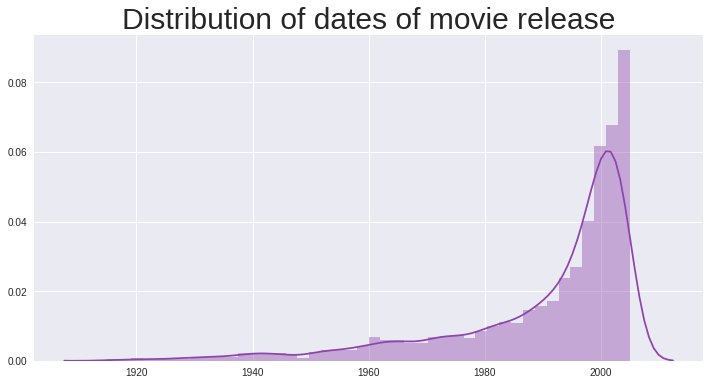

In [36]:
'''Plotting the distribution of number of movie released in the years'''
plt.figure(figsize=(12,6))
sns.distplot(year_of_movies,color='#8E44AD');
plt.title('Distribution of dates of movie release',fontdict={'fontsize':30})
plt.savefig('Distribution_of_movie_release.png')
plt.show()

We can conclude that most of the movies in our dataset had released during the 20's.

In [37]:
'''Retrieving the date of rating'''
date = df.Date.tolist()

In [38]:
'''Extracting the year from the full date'''
date = [i[:4] for i in date]

In [39]:
'''Creating a new feature called year'''
df['Year'] = date; 

In [40]:
df.head(3)

CustomerID  Score        Date  MovieID  Year
0     1488844      3  2005-09-06        1  2005
1      822109      5  2005-05-13        1  2005
2      885013      4  2005-10-19        1  2005

In [41]:
min(date), max(date)

('1999', '2005')

In [42]:
'''Calculating the percentage of ratings in a year'''
l = len(date); percentage = []
flag = list(set(date))
flag.sort()
for i in flag:
    percentage.append(date.count(i)/l)
y = 1999
print("Year  Percentage")
for i in range(len(percentage)):
    print ('{}: {}'.format(y,percentage[i]*100))
    y += 1

Year  Percentage
1999: 0.0017710325918222193
2000: 0.8034293510155002
2001: 1.541093526983968
2002: 3.989180238070017
2003: 9.969287966739842
2004: 31.469619474108086
2005: 52.22561841049077


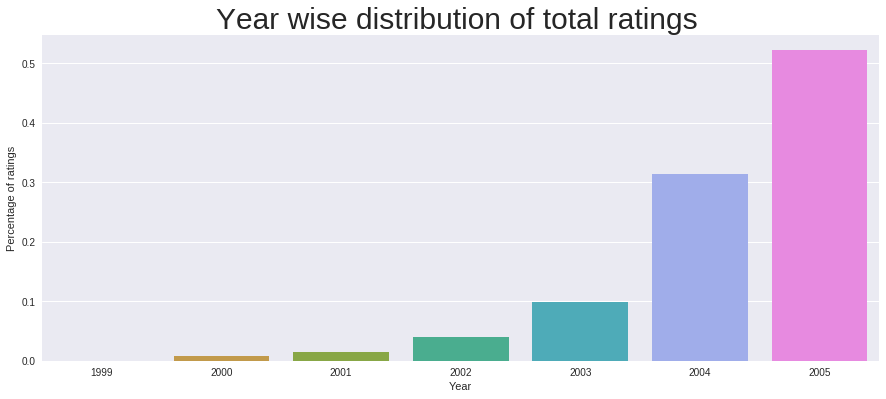

In [43]:
plt.figure(figsize=(15,6))
sns.barplot(x=flag,y=percentage)
plt.title('Year wise distribution of total ratings ',fontdict={'fontsize':30})
plt.xlabel('Year'); plt.ylabel('Percentage of ratings')
plt.savefig('Year_wise_distribution_of_total_ratings.png')
plt.show()

In [44]:
import pickle

In a pickle file we had stored 470,758 values, each value represents the year of 1st rating that a user gave. Computing this list was taking a lot of time so we computed it in another laptop and stored the result.

In [45]:
with open('year_1st_rating.txt','rb') as fp:
    year_1st_rating = pickle.load(fp)
del fp

In [46]:
'''The values were originally in string format.
Therefore converting them in integer'''
year_1st_rating = list(map(int, year_1st_rating))

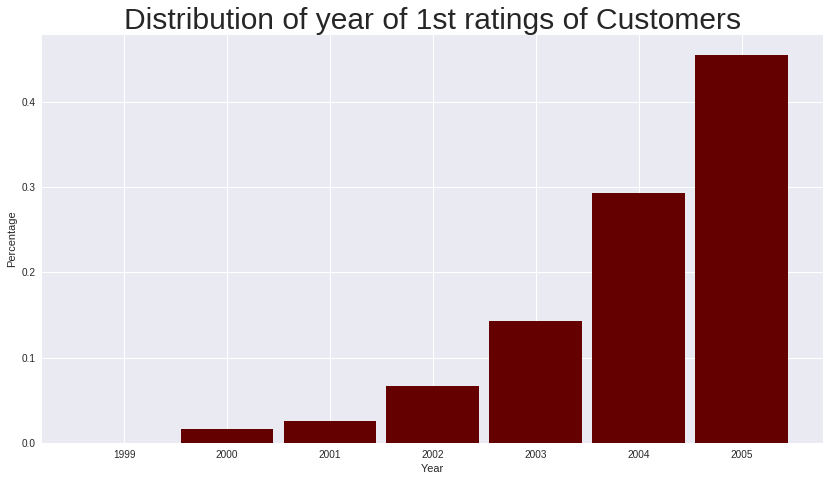

In [47]:
plt.figure(figsize=(14,7.5))
plt.hist(year_1st_rating,bins=[1999,2000,2001,2002,2003,2004,2005,2006]\
        ,rwidth=0.9,color='#650000',normed=True)
plt.xticks([1999.5,2000.5,2001.5,2002.5,2003.5,2004.5,2005.5],\
           [1999,2000,2001,2002,2003,2004,2005])
plt.xlabel('Year');plt.ylabel('Percentage')
plt.title('Distribution of year of 1st ratings of Customers',fontdict={'fontsize':30})
plt.savefig('Distribution_year_1st_ratings_Customers.png')
plt.show()

Since Netflix doesn't disclose the joining date of the users we can consider the year in which the user rated a movie first as the joining year.<br>
If we assume that, then we can conclude that netflix had the most number of users in 2004 and 2005.

In [48]:
del year_1st_rating

In [49]:
del date;

In [50]:
from collections import Counter

In [51]:
'''Finding the unique customers and the frequency of their rating'''
fre = dict(Counter(df.CustomerID))

In [52]:
import numpy as np
flag = np.array(list(fre.values()))

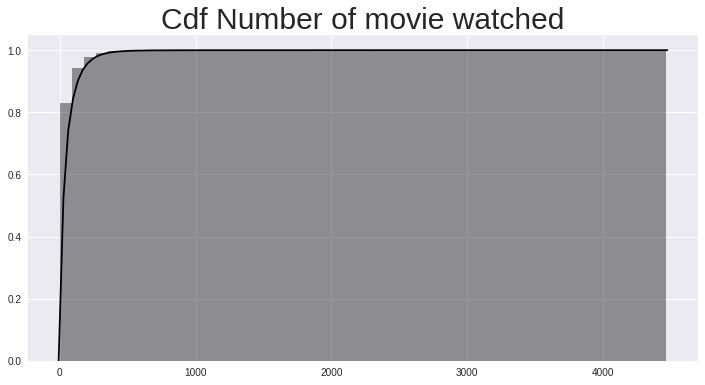

In [53]:
plt.figure(figsize=(12,6))
sns.distplot(flag,hist_kws={'cumulative': True},\
             kde_kws={'cumulative': True},color='black')
plt.title('Cdf Number of movie watched',fontdict={'fontsize':30})
plt.savefig('Cdf_Number_of_movie_watched.png')
plt.show()

In [54]:
print ('50th percentile: {}\n75th percentile: {}\nMaximum: {}'\
       .format(np.percentile(flag,50),np.percentile(flag,75),max(flag)))

50th percentile: 24.0
75th percentile: 64.0
Maximum: 4467


We had an array of number of movies watched by the user, we took the 75th percentile and used it as a threshold to decide whether someone is a frequent customer or not.

In [55]:
'''If the user has rated more than 64 movie in the set of 4499
movies then he is frequent or else he is not'''
fvnf = []; tmp = np.percentile(flag,75)
for i in list(df.CustomerID):
    if(fre[i]>tmp):
        fvnf.append('F')
    else:
        fvnf.append('NF')

In [56]:
del flag

In [57]:
del fre
'''Creating a new column in the datframe to store Frequent/Non-frequent'''
df['Freq_nFreq'] = fvnf
del fvnf

In [58]:
'''Retrieving the distribution of scores given by frequent and non-frequent users'''
score_f = df[df.Freq_nFreq == 'F'].Score.tolist()
score_nf = df[df.Freq_nFreq == 'NF'].Score.tolist()

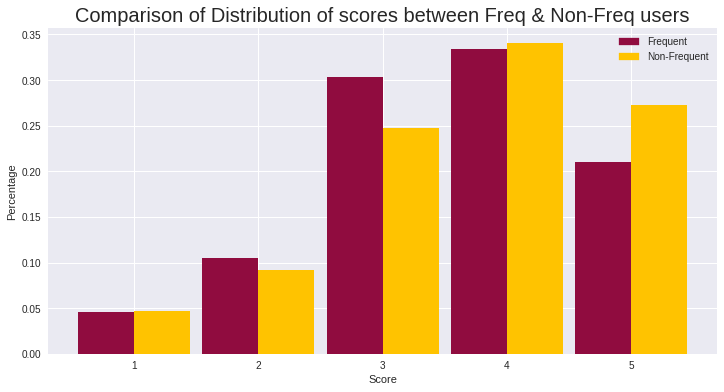

In [59]:
import matplotlib.patches as mpatches

'''Plotting the histogram of scores'''
plt.figure(figsize=(12,6))
plt.hist(x=[score_f,score_nf],bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color=['#900c3f','#ffc300']);
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Comparison of Distribution of scores between Freq & Non-Freq users',fontdict={'fontsize':20})
plt.xlabel('Score'); plt.ylabel('Percentage')

red_patch = mpatches.Patch(color='#900c3f', label='Frequent')
black_patch = mpatches.Patch(color='#ffc300', label='Non-Frequent')
plt.legend(handles=[red_patch,black_patch])

plt.savefig('Comparison_of_Distribution_of_scores_freq_nfreq.png')
plt.show()

From here we can see that frequent reviewers are more critacal in their ratings as they give more percentage of 1,2 and 3 stars than 4 and 5 stars.

In [60]:
del score_f; del score_nf

In [61]:
'''Retriving the scores of 2005'''
score_2005 = df[df.Year == str(2005)].Score.tolist()

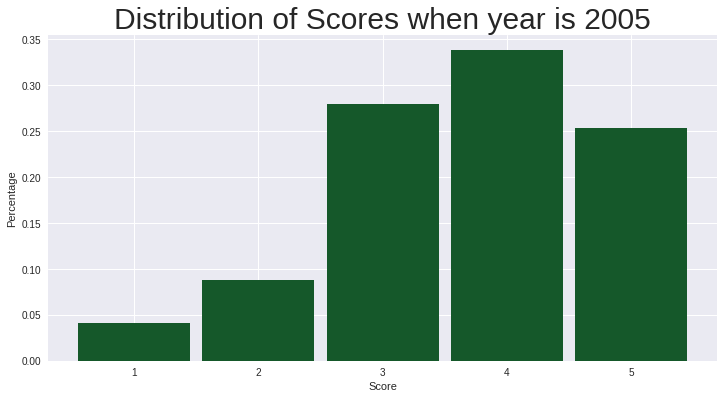

In [62]:
'''Plotting the histogram of scores in the year 2005
when netflix was the most popular in '''
plt.figure(figsize=(12,6))
plt.hist(x=score_2005,bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color='#15582A');
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores when year is 2005',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_scores_when_year2005.png')
plt.show()

del score_2005

So we can see that in 2005 distribution of scores was almost same as that of the total distribution

In [63]:
'''Retriving the scores of 2004'''
score_2004 = df[df.Year == str(2004)].Score.tolist()

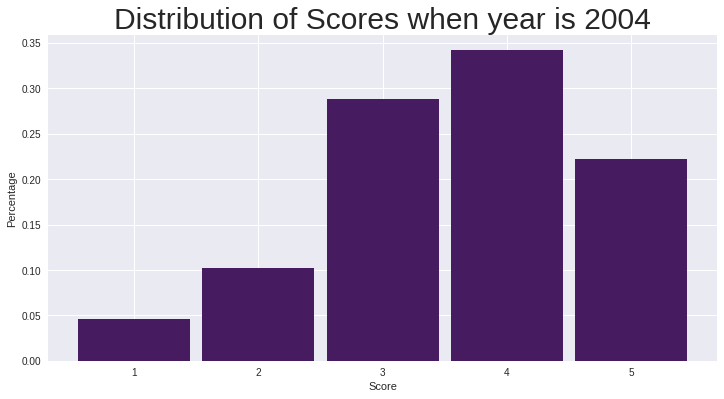

In [64]:
'''Plotting the histogram of scores in the year 2004
'''
plt.figure(figsize=(12,6))
plt.hist(x=score_2004,bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color='#461B60');
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores when year is 2004',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_scores_when_year2004.png')
plt.show()

del score_2004

In [65]:
'''Retriving the scores of 2003'''
score_2003 = df[df.Year == str(2003)].Score.tolist()

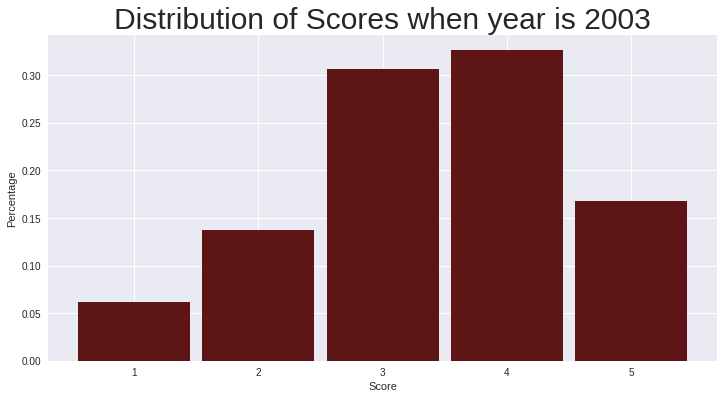

In [66]:
'''Plotting the histogram of scores in the year 2003
when netflix was the most popular in '''
plt.figure(figsize=(12,6))
plt.hist(x=score_2003,bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color='#5D1515');
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores when year is 2003',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_scores_when_year2003.png')
plt.show()

del score_2003

In [67]:
'''Retriving the scores of 2002'''
score_2002 = df[df.Year == str(2002)].Score.tolist()

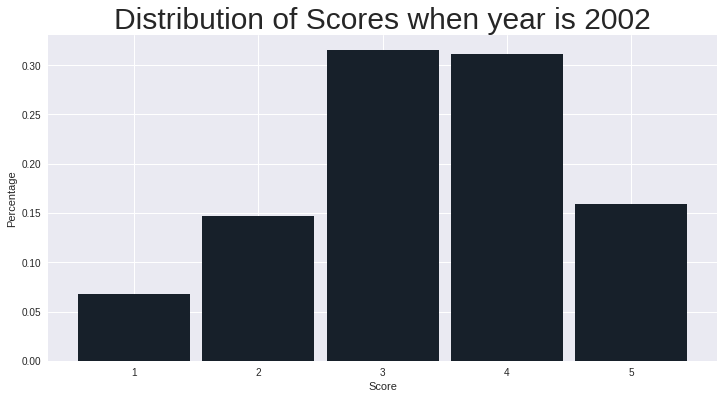

In [68]:
'''Plotting the histogram of scores in the year 2002
when netflix was the most popular in '''
plt.figure(figsize=(12,6))
plt.hist(x=score_2002,bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color='#17202A');
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores when year is 2002',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_scores_when_year2002.png')
plt.show()

del score_2002

We can see that in 2002, number of 3 stars surpased the number of 4 stars.<br>Now let's compare them altogether

In [69]:
'''Retriving the scores of over the last 4 years'''
score_2005 = df[df.Year == str(2005)].Score.tolist()
score_2004 = df[df.Year == str(2004)].Score.tolist()
score_2003 = df[df.Year == str(2003)].Score.tolist()
score_2002 = df[df.Year == str(2002)].Score.tolist()

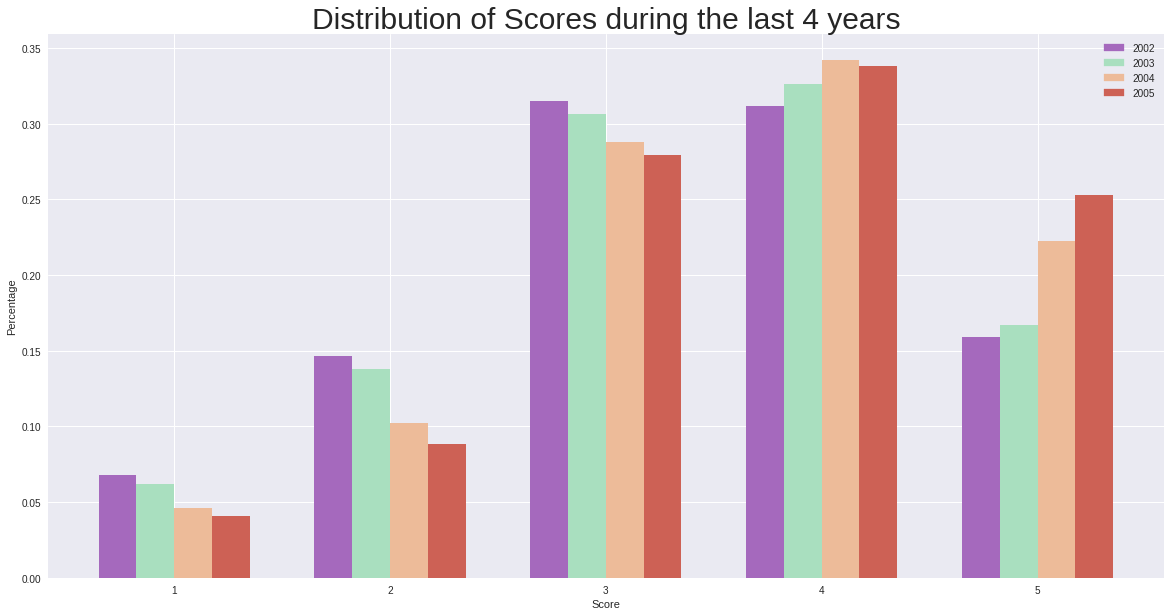

In [70]:
'''Plotting the histogram of scores in the year 2004
when netflix was the most popular in '''
plt.figure(figsize=(20,10))
clr = ['#A569BD','#A9DFBF','#EDBB99','#CD6155']
plt.hist(x=[score_2002,score_2003,score_2004,score_2005],bins=[1,2,3,4,5,6],\
         rwidth=0.7,normed=True,color=clr);
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores during the last 4 years',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')

patch_2002 = mpatches.Patch(color=clr[0], label='2002')
patch_2003 = mpatches.Patch(color=clr[1], label='2003')
patch_2004 = mpatches.Patch(color=clr[2], label='2004')
patch_2005 = mpatches.Patch(color=clr[3], label='2005')

plt.legend(handles=[patch_2002,patch_2003,patch_2004,patch_2005])

plt.savefig('Distribution_of_scores_during_last_4_years.png')
plt.show()

So, we can see that low ratings were given more in 2002 and onwards and in the recent years, more high ratings were given<br>
<br><br>
**Hypothesis:**<br>
1. Frequent users who give critical ratings, rated more in 2004 and 2005.
2. More number of good movies were launched in 2004 and 2005

In [71]:
del score_2002, score_2003, score_2004, score_2005

In [72]:
'''Retriveing the number of reviews per movie'''
fre = dict(Counter(df.MovieID))

In [73]:
import operator
'''Sorting the movies based on the frequncy of ratings it got'''
fre = sorted(fre.items(), key=operator.itemgetter(1),reverse=True)

In [74]:
'''These are the top movies with their review of ratings'''
fre[:2]

[(1905, 193941), (2152, 162597)]

So the movie with id:1905(Pirates of the caribbean) was the most watched movie in the dataset.<br>
Now let's do some analysis on that movie

In [75]:
'''Retrieving the scores of the most rated movie'''
score_movie1905 = df[df.MovieID == 1905]

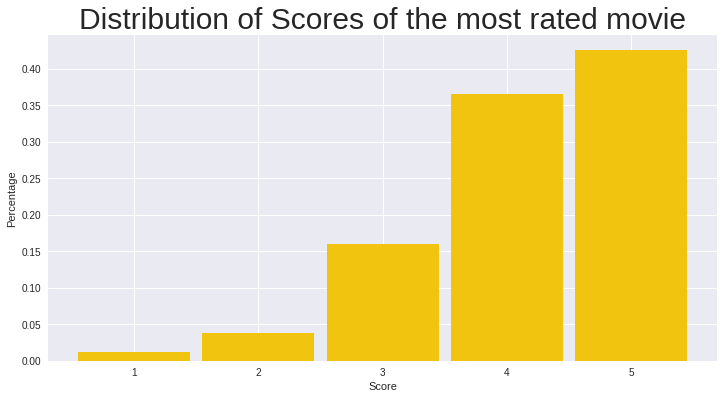

In [76]:
'''Plotting the distribution of scores of the most rated movie'''
plt.figure(figsize=(12,6))
plt.hist(x=score_movie1905.Score,bins=[1,2,3,4,5,6],rwidth=0.9,normed=True,color='#F1C40F');
plt.xticks([1.5,2.5,3.5,4.5,5.5],[1,2,3,4,5])
plt.title('Distribution of Scores of the most rated movie',fontdict={'fontsize':30})
plt.xlabel('Score'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_scores_most_rated_movie.png')
plt.show()

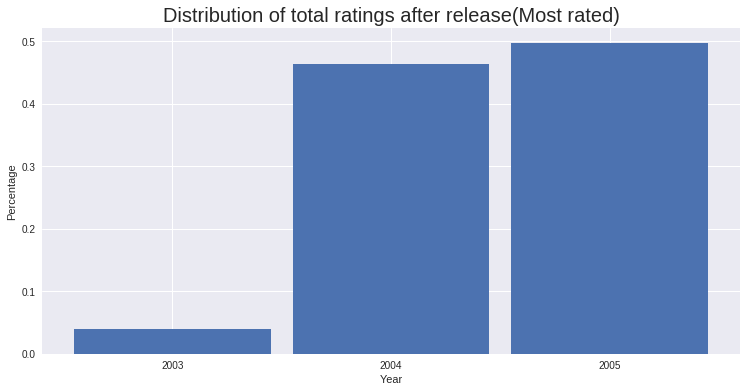

In [77]:
'''Plotting the distribution to see how many ratings it got 
in the upcoming years'''
plt.figure(figsize=(12.5,6))
plt.hist(x=list(map(int, score_movie1905.Year)),\
         rwidth=0.9,normed=True,bins=[2003,2004,2005,2006]);
plt.xticks([2003.5,2004.5,2005.5],[2003,2004,2005])
plt.title('Distribution of total ratings after release(Most rated)',fontdict={'fontsize':20})
plt.xlabel('Year'); plt.ylabel('Percentage')
plt.savefig('Distribution_of_total_ratings_most_rated_movie.png')
plt.show()

In [78]:
del score_movie1905

__Down below we have the code that creates a dataframe that describes the movies, total rating it got, standard deviation and mean.<br>
We did it for only a part of the movies and then other parts in other computers to reduce time.
We are storing the datframe in a file in 4 parts <br>info-(1,2,3,4).pkl__
<br>Note: No need to run this part of code again

In [79]:
'''import numpy as np
_1, _2, _3, _4 = [], [], [], []
for i in sorted(list(set(df.MovieID)))[:1500]:
    score_i = df[df.MovieID == i].Score.tolist() 
    _1.append(i); _2.append(len(score_i)); _3.append(np.mean(score_i)); _4.append(np.std(score_i))
    
col = ['MovieID','NumberOfRating','MeanRating','StdDev']
info = pd.DataFrame(columns = col);
info['MovieID']=_1; info['NumberOfRating']=_2; info['MeanRating']=_3; info['StdDev']=_4
del _1, _2, _3, _4, score_i
info.to_pickle('info_1.pkl')
del info
'''
print()

In [80]:
'''Loading the dataframe that we previously saved'''
info = pd.concat([pd.read_pickle('info_1.pkl'),pd.read_pickle('info_2.pkl'),\
                 pd.read_pickle('info_3.pkl')])

In [81]:
info.columns

Index(['MovieID', 'NumberOfRating', 'MeanRating', 'StdDev'], dtype='object')

In [82]:
info.head(5)

MovieID  NumberOfRating  MeanRating    StdDev
0        1             547    3.749543  1.066943
1        2             145    3.558621  1.275098
2        3            2012    3.641153  0.977102
3        4             142    2.739437  1.298317
4        5            1140    3.919298  1.291869

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

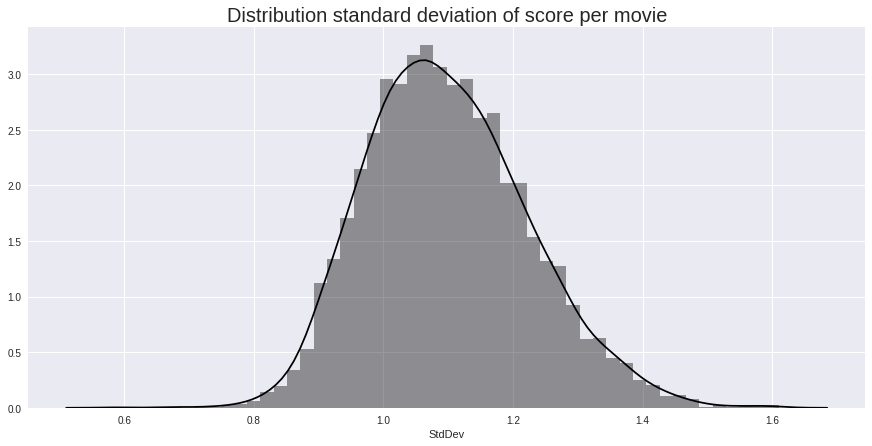

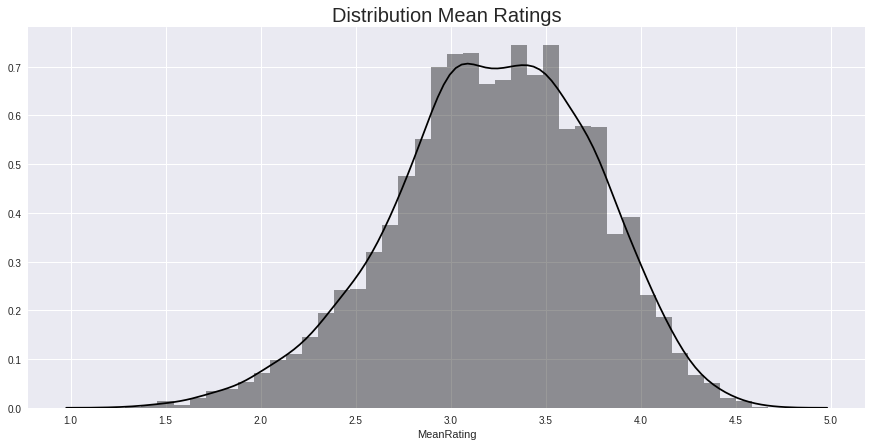

Minimum std dev: 0.5842672571108739	Maximum std dev: 1.611181371650441
Minimum mean rating: 1.2878787878787878	Maximum mean rating: 4.6709891019450955


In [84]:
plt.figure(figsize=(15,7))
ax1 = sns.distplot(info.StdDev,color='black')
plt.title('Distribution standard deviation of score per movie',fontdict={'fontsize':20})
plt.savefig('Distribution_of_std_dev_Scores_per_movie.png')
plt.show()

plt.figure(figsize=(15,7))
ax2 = sns.distplot(info.MeanRating,color='black')
plt.title('Distribution Mean Ratings',fontdict={'fontsize':20})
plt.savefig('Distribution_of_Mean_Ratings.png')
plt.show()

print ('Minimum std dev: {}\tMaximum std dev: {}'.format(min(info.StdDev),max(info.StdDev)))
print ('Minimum mean rating: {}\tMaximum mean rating: {}'.format(min(info.MeanRating),max(info.MeanRating)))

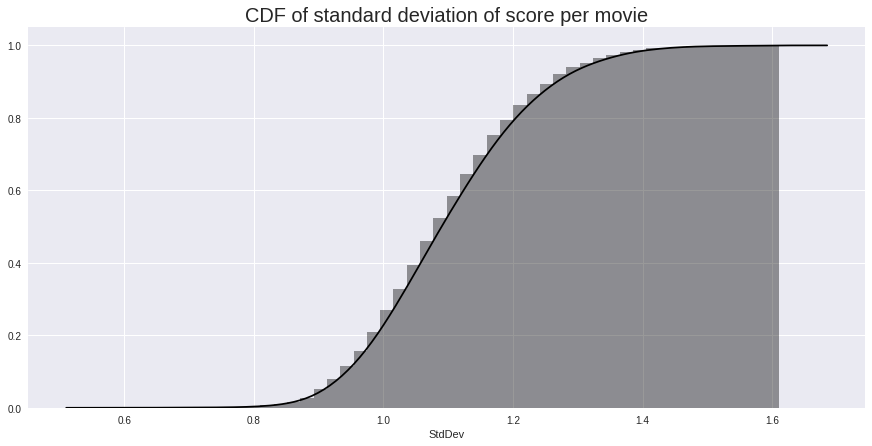

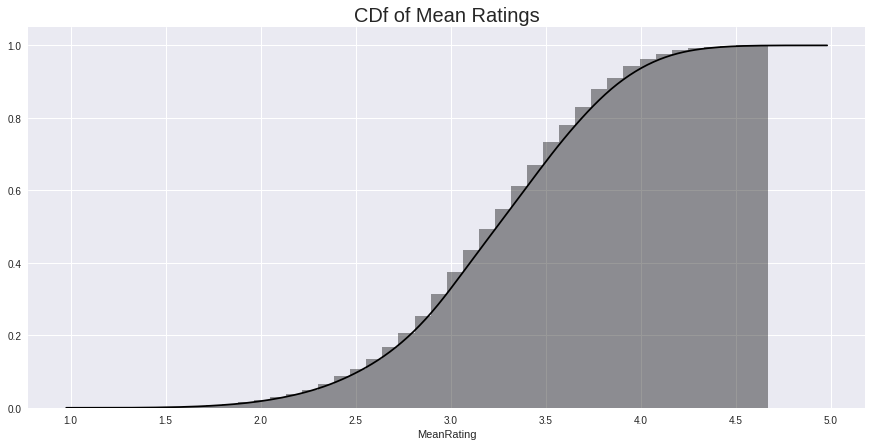

In [85]:
plt.figure(figsize=(15,7))
sns.distplot(info.StdDev,color='black',\
             hist_kws={'cumulative': True},
             kde_kws={'cumulative': True})
plt.title('CDF of standard deviation of score per movie',fontdict={'fontsize':20})
plt.savefig('CDF_of_std_dev_Scores_per_movie.png')
plt.show()

plt.figure(figsize=(15,7))
sns.distplot(info.MeanRating,color='black',\
             hist_kws={'cumulative': True},
             kde_kws={'cumulative': True})
plt.title('CDf of Mean Ratings',fontdict={'fontsize':20})
plt.savefig('CDF_of_Mean_Ratings.png')
plt.show()


In the cell below we are calculating every user's first rating year and saving it in a file<br>
Note: No need to run the code again

In [86]:
'''list_of_customer = sorted(list(set(df.CustomerID)))

year_1st_rating = [];
for i in list_of_customer:
    date = min(list(df[df.CustomerID == i].Date))
    year_1st_rating.append(date[:4])'''
print()

In [87]:
getsizeof(info),getsizeof(df)

(179984, 5193893641)

In [88]:
del df